In [1]:
import sys
import os
sys.path.append(os.path.relpath('../'))
import numpy as np
from multi_condensed import Problem
from math import sqrt, cosh, cos, sinh, sin, pi
from scipy.optimize import newton, minimize_scalar
from multi_condensed import Problem


In [16]:
# constants block
h = 50.0
d = np.array([29.0, 7.0, 5.5, 4.0])
a = np.array([3.0, 5.0, 7.5, 10.0])
heaving = [0, 1, 1, 1] # 0/false if not heaving, 1/true if yes heaving
slant = [0, 1, 1, 1] # 0/false if not slanted, 1/true if yes slanted
NMK = [20, 20, 20, 20, 20]
omega = 0.4
# # omega = np.linspace(0.1, 1.5, 15)
rho = 1023


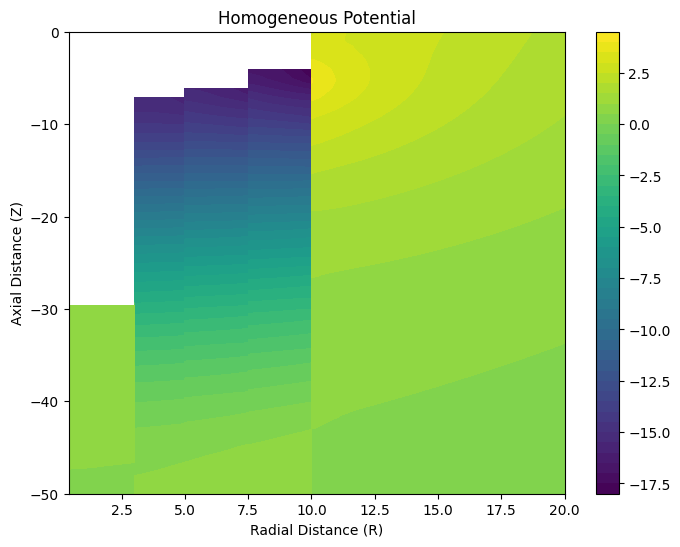

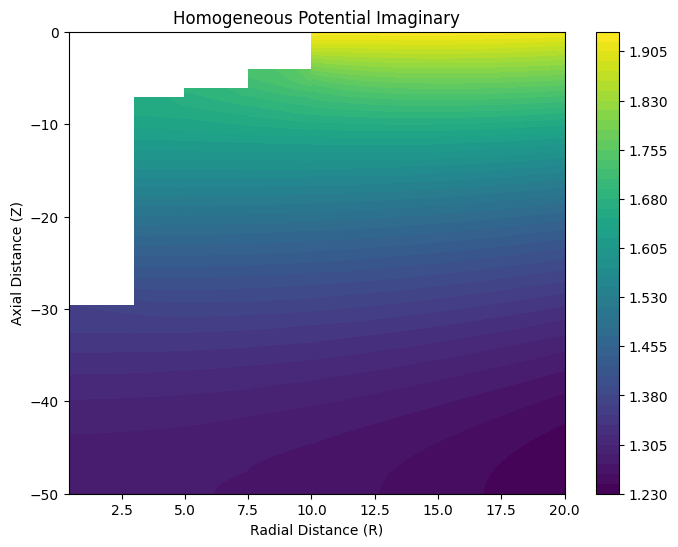

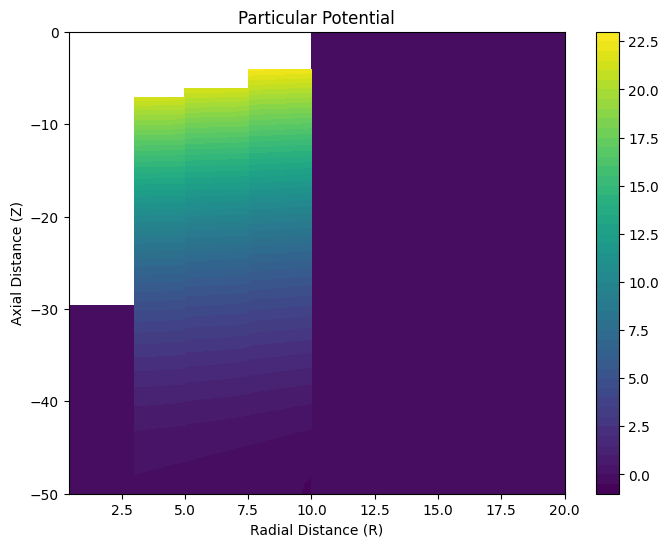

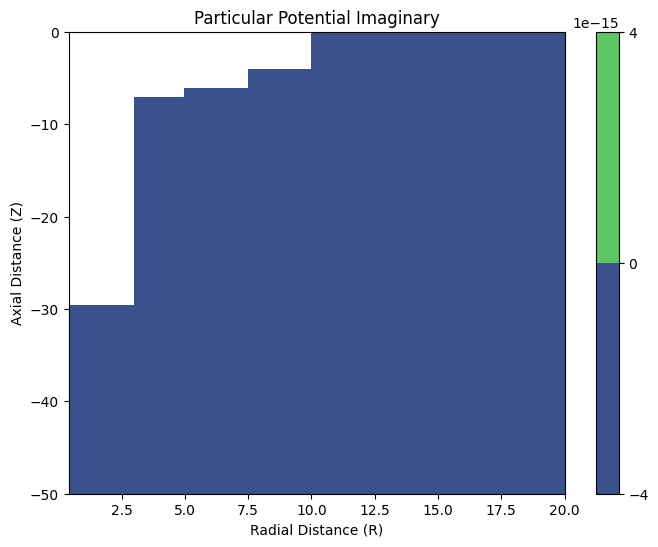

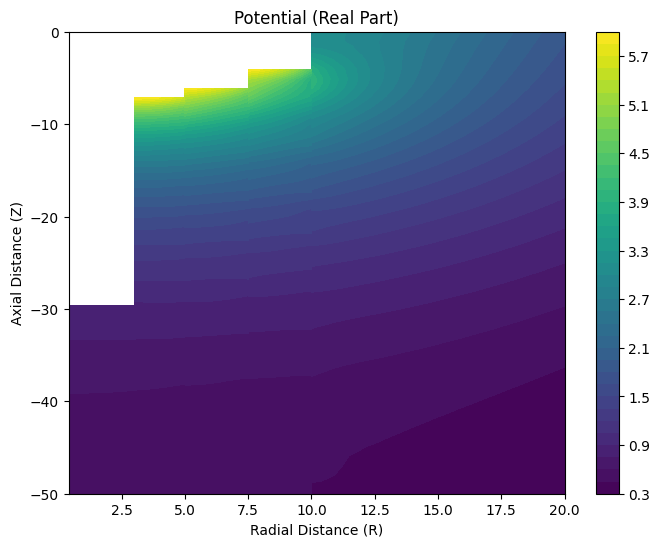

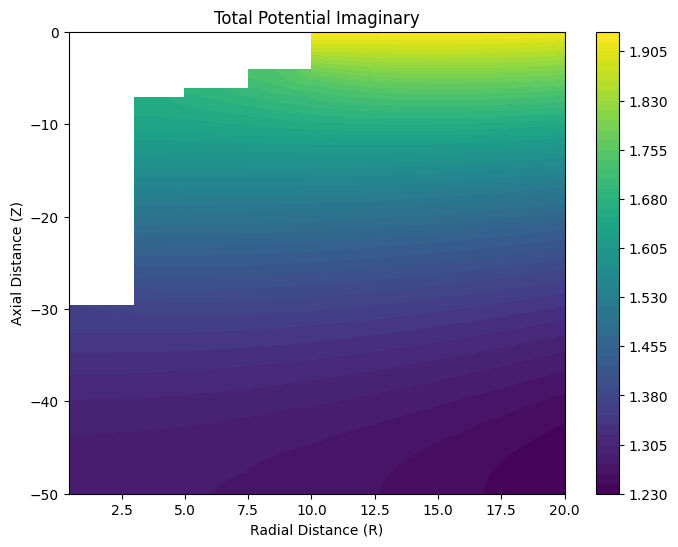

1688522.3217225352 200481.84605783905


In [21]:
prob = Problem(h, d, a, heaving, NMK, 1, rho)
prob.change_m0(prob.wavenumber(omega))
a_matrix = prob.a_matrix()
b_vector = prob.b_vector()
x = prob.get_unknown_coeffs(a_matrix, b_vector)
Cs = prob.reformat_coeffs(x)

am, dp = prob.hydro_coeffs(x, "capytaine")
boundary_count = prob.boundary_count
prob.plot_potentials(Cs)

print(am, dp)

In [18]:
def phi_h_n_inner_func(n, r, z):
    return (Cs[0][n] * prob.R_1n(n, r, 0)) * prob.Z_n_i(n, z, 0)

def phi_h_m_i_func(i, m, r, z):
    return (Cs[i][m] * prob.R_1n(m, r, i) + Cs[i][NMK[i] + m] * prob.R_2n(m, r, i)) * prob.Z_n_i(m, z, i)

def phi_e_k_func(k, r, z):
    return Cs[-1][k] * prob.Lambda_k(k, r) * prob.Z_k_e(k, z)

def phi_p_i(d, r, z): # particular solution
            return (1 / (2* (h - d))) * ((z + h) ** 2 - (r**2) / 2)

phi_e_k_vec = np.vectorize(phi_e_k_func, otypes = [complex])
phi_h_n_inner_vec = np.vectorize(phi_h_n_inner_func, otypes = [complex])
phi_h_m_i_vec = np.vectorize(phi_h_m_i_func, otypes = [complex])
phi_p_i_vec = np.vectorize(phi_p_i)

spatial_res=50
r_vec = np.linspace(2 * a[-1] / spatial_res, 2*a[-1], spatial_res)
z_vec = np.linspace(-h, 0, spatial_res)

#add values at the radii
a_eps = 1.0e-4
for i in range(len(a)):
    r_vec = np.append(r_vec, a[i]*(1-a_eps))
    r_vec = np.append(r_vec, a[i]*(1+a_eps))
r_vec = np.unique(r_vec)

for i in range(len(d)):
    z_vec = np.append(z_vec, -d[i]*(1-a_eps))
    z_vec = np.append(z_vec, -d[i]*(1+a_eps))
z_vec = np.unique(z_vec)

R, Z = np.meshgrid(r_vec, z_vec)
 

regions = []
regions.append((R <= a[0]) & (Z < -d[0]))
for i in range(1, boundary_count):
    regions.append((R > a[i-1]) & (R <= a[i]) & (Z < -d[i]))
regions.append(R > a[-1])

phi = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 

for n in range(NMK[0]):
    temp_phiH = phi_h_n_inner_vec(n, R[regions[0]], Z[regions[0]])
    phiH[regions[0]] = temp_phiH if n == 0 else phiH[regions[0]] + temp_phiH

for i in range(1, boundary_count):
    for m in range(NMK[i]):
        temp_phiH = phi_h_m_i_vec(i, m, R[regions[i]], Z[regions[i]])
        phiH[regions[i]] = temp_phiH if m == 0 else phiH[regions[i]] + temp_phiH

for k in range(NMK[-1]):
    temp_phiH = phi_e_k_vec(k, R[regions[-1]], Z[regions[-1]])
    phiH[regions[-1]] = temp_phiH if k == 0 else phiH[regions[-1]] + temp_phiH

phiP[regions[0]] = heaving[0] * phi_p_i_vec(d[0], R[regions[0]], Z[regions[0]])
for i in range(1, boundary_count):
    phiP[regions[i]] = heaving[i] * phi_p_i_vec(d[i], R[regions[i]], Z[regions[i]])
phiP[regions[-1]] = 0

phi = phiH + phiP


Goal: Solve for hydrocoefficients when the body is slanted

Approach: Using the the potentials at the two corners to estimate d_phi/d_z by applying trigonometry.

Problem: The the values for hydrocoefficients are too small

In [19]:
hydro_terms = np.zeros((prob.size - NMK[-1]), dtype=complex)
vel_z = np.zeros(len(NMK)-1, dtype=complex)

col = 0
region_indx = 0
for n in range(NMK[0]):
    if slant[0]:
        #need definition
        pass 
    else:
        hydro_terms[n] = prob.int_R_1n(0, n)* x[n] * prob.z_n_d(n)
col += NMK[0]
region_indx += 1
for i in range(1, boundary_count):
    M = NMK[i]
    if slant[i]:
        #bottom_corner
        r_index = np.where(r_vec == a[i-1]*(1+a_eps))
        z_index = np.where(z_vec == -d[i-1]*(1-a_eps))
        phi_bttm_corner1 = phi[z_index, r_index]

        #top__corner
        r_index = np.where(r_vec == a[i]*(1-a_eps))
        z_index = np.where(z_vec == -d[i]*(1+a_eps))
        phi_top_corner1 = phi[z_index, r_index]
        
        #slant velocity z component approximation
        vel_z[i] = (phi_top_corner1 - phi_bttm_corner1)*(d[i-1]-d[i])/((d[i-1]-d[i])**2+(a[i]-a[i-1])**2)
        
        for m in range(M):
            hydro_terms[col + m] = vel_z[i] * prob.int_R_1n(i, m)* x[col + m] * prob.z_n_d(m)
            hydro_terms[col + M + m] = vel_z[i] * prob.int_R_2n(i, m)* x[col + M + m] * prob.z_n_d(m)
    else:
        for m in range(M):
            hydro_terms[col + m] = prob.int_R_1n(i, m)* x[col + m] * prob.z_n_d(m)
            hydro_terms[col + M + m] = prob.int_R_2n(i, m)* x[col + M + m] * prob.z_n_d(m)
    col += 2 * M
    region_indx += 1

hydro_p_terms = np.zeros(boundary_count, dtype=complex)
for i in range(boundary_count):
    if not heaving[i]:
        hydro_p_terms[i] = 0
    elif slant[i]:
        hydro_p_terms[i] = vel_z[i] * prob.int_phi_p_i(i)
    else:
        hydro_p_terms[i] = prob.int_phi_p_i(i)


hydro_coef =2*pi*(sum(hydro_terms) + sum(hydro_p_terms))
hydro_coef_real = hydro_coef.real * h**3 * rho
hydro_coef_imag = hydro_coef.imag * omega * h**3 * rho

# find maximum heaving radius
max_rad = a[0]
for i in range(boundary_count - 1, 0, -1):
    if heaving[i]:
        max_rad = a[i]
        break

hydro_coef_nondim = h**3/(max_rad**3 * pi)*hydro_coef

# print("real (added mass):", hydro_coef_real)
# print("imag (damping):", hydro_coef_imag)
print("real/(h^3):", hydro_coef_real/(h**3)) # to compare with Capytaine
print("imag/(h^3):", hydro_coef_imag/(h**3))
# print("nondimensional, real:", hydro_coef_nondim.real)
# print("nondimensional, imag (no omega factor):", hydro_coef_nondim.imag)


real/(h^3): 6674.014345994126
imag/(h^3): 18816.81728027487


/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_26553/2029487052.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vel_z[i] = (phi_top_corner1 - phi_bttm_corner1)*(d[i-1]-d[i])/((d[i-1]-d[i])**2+(a[i]-a[i-1])**2)


In [14]:
hydro_terms = np.zeros((prob.size - NMK[-1]), dtype=complex)
cos_theta = np.zeros(len(NMK)-1, dtype=complex)
sin_theta = np.zeros(len(NMK)-1, dtype=complex)
delta_phi = np.zeros(len(NMK)-1, dtype=complex)

col = 0
region_indx = 0
for n in range(NMK[0]):
    if slant[0]:
        #need definition
        pass 
    else:
        hydro_terms[n] = prob.int_R_1n(0, n)* x[n] * prob.z_n_d(n)
col += NMK[0]
region_indx += 1
for i in range(1, boundary_count):
    M = NMK[i]
    if slant[i]:
        #slant velocity z component approximation
        cos_theta[i] = (d[i-1]-d[i])/((d[i-1]-d[i])**2+(a[i]-a[i-1])**2)
        sin_theta[i] = (a[i]-a[i-1])/((d[i-1]-d[i])**2+(a[i]-a[i-1])**2)

        #bottom_corner
        r_index = np.where(r_vec == a[i-1]*(1+a_eps))
        z_index = np.where(z_vec == -d[i-1]*(1-a_eps))
        phi_bttm_corner = phi[z_index, r_index]

        #top__corner
        r_index = np.where(r_vec == a[i]*(1-a_eps))
        z_index = np.where(z_vec == -d[i]*(1+a_eps))
        phi_top_corner = phi[z_index, r_index]
        delta_phi[i] = phi_top_corner - phi_bttm_corner

        for m in range(M):
            hydro_terms[col + m] = delta_phi[i]*cos_theta[i]*sin_theta[i] * prob.int_R_1n(i, m)* x[col + m] * prob.z_n_d(m)
            hydro_terms[col + M + m] = delta_phi[i]*cos_theta[i]*sin_theta[i] * prob.int_R_2n(i, m)* x[col + M + m] * prob.z_n_d(m)
    else:
        for m in range(M):
            hydro_terms[col + m] = prob.int_R_1n(i, m)* x[col + m] * prob.z_n_d(m)
            hydro_terms[col + M + m] = prob.int_R_2n(i, m)* x[col + M + m] * prob.z_n_d(m)
    col += 2 * M
    region_indx += 1

hydro_p_terms = np.zeros(boundary_count, dtype=complex)
for i in range(boundary_count):
    if not heaving[i]:
        hydro_p_terms[i] = 0
    elif slant[i]:
        hydro_p_terms[i] = delta_phi[i]*cos_theta[i]*sin_theta[i]*prob.int_phi_p_i(i)
    else:
        hydro_p_terms[i] = prob.int_phi_p_i(i)


hydro_coef =2*pi*(sum(hydro_terms) + sum(hydro_p_terms))
hydro_coef_real = hydro_coef.real * h**3 * rho
hydro_coef_imag = hydro_coef.imag * omega * h**3 * rho

# find maximum heaving radius
max_rad = a[0]
for i in range(boundary_count - 1, 0, -1):
    if heaving[i]:
        max_rad = a[i]
        break

hydro_coef_nondim = h**3/(max_rad**3 * pi)*hydro_coef

# print("real (added mass):", hydro_coef_real)
# print("imag (damping):", hydro_coef_imag)
print("real/(h^3):", hydro_coef_real/(h**3)) # to compare with Capytaine
print("imag/(h^3):", hydro_coef_imag/(h**3))
# print("nondimensional, real:", hydro_coef_nondim.real)
# print("nondimensional, imag (no omega factor):", hydro_coef_nondim.imag)

real/(h^3): 55018.71467376608
imag/(h^3): 15225.50199157926


/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_26553/3123473433.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_phi[i] = phi_top_corner - phi_bttm_corner


In [23]:
hydro_terms = np.zeros((prob.size - NMK[-1]), dtype=complex)
vel_z = np.zeros(len(NMK)-1, dtype=complex)

col = 0
region_indx = 0
for n in range(NMK[0]):
    if slant[0]:
        #need definition
        pass 
    else:
        hydro_terms[n] = prob.int_R_1n(0, n)* x[n] * prob.z_n_d(n)
col += NMK[0]
region_indx += 1
for i in range(1, boundary_count):
    M = NMK[i]
    if slant[i]:
        #bottom_corner
        r_index = np.where(r_vec == a[i-1]*(1+a_eps))
        z_index = np.where(z_vec == -d[i-1]*(1-a_eps))
        phi_bttm_corner1 = phi[z_index, r_index]

        #top__corner
        r_index = np.where(r_vec == a[i]*(1-a_eps))
        z_index = np.where(z_vec == -d[i]*(1+a_eps))
        phi_top_corner1 = phi[z_index, r_index]
        
        #slant velocity z component approximation
        vel_z[i] = (phi_top_corner1 - phi_bttm_corner1)/(d[i-1]-d[i])
        
        for m in range(M):
            hydro_terms[col + m] = vel_z[i] * prob.int_R_1n(i, m)* x[col + m] * prob.z_n_d(m)
            hydro_terms[col + M + m] = vel_z[i] * prob.int_R_2n(i, m)* x[col + M + m] * prob.z_n_d(m)
    else:
        for m in range(M):
            hydro_terms[col + m] = prob.int_R_1n(i, m)* x[col + m] * prob.z_n_d(m)
            hydro_terms[col + M + m] = prob.int_R_2n(i, m)* x[col + M + m] * prob.z_n_d(m)
    col += 2 * M
    region_indx += 1

hydro_p_terms = np.zeros(boundary_count, dtype=complex)
for i in range(boundary_count):
    if not heaving[i]:
        hydro_p_terms[i] = 0
    elif slant[i]:
        hydro_p_terms[i] = vel_z[i] * prob.int_phi_p_i(i)
    else:
        hydro_p_terms[i] = prob.int_phi_p_i(i)


hydro_coef =2*pi*(sum(hydro_terms) + sum(hydro_p_terms))
hydro_coef_real = hydro_coef.real * h**3 * rho
hydro_coef_imag = hydro_coef.imag * omega * h**3 * rho

# find maximum heaving radius
max_rad = a[0]
for i in range(boundary_count - 1, 0, -1):
    if heaving[i]:
        max_rad = a[i]
        break

hydro_coef_nondim = h**3/(max_rad**3 * pi)*hydro_coef

# print("real (added mass):", hydro_coef_real)
# print("imag (damping):", hydro_coef_imag)
print("real/(h^3):", hydro_coef_real/(h**3)) # to compare with Capytaine
print("imag/(h^3):", hydro_coef_imag/(h**3))
# print("nondimensional, real:", hydro_coef_nondim.real)
# print("nondimensional, imag (no omega factor):", hydro_coef_nondim.imag)

real/(h^3): -221942.777763335
imag/(h^3): 2356.7045317591646


/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_26553/2217290234.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vel_z[i] = (phi_top_corner1 - phi_bttm_corner1)/(d[i-1]-d[i])


In [24]:
hydro_terms = np.zeros((prob.size - NMK[-1]), dtype=complex)
vel_z = np.zeros(len(NMK)-1, dtype=complex)
cos_theta = np.zeros(len(NMK)-1, dtype=complex)

col = 0
region_indx = 0
for n in range(NMK[0]):
    if slant[0]:
        #need definition
        pass 
    else:
        hydro_terms[n] = prob.int_R_1n(0, n)* x[n] * prob.z_n_d(n)
col += NMK[0]
region_indx += 1
for i in range(1, boundary_count):
    M = NMK[i]
    if slant[i]:
        cos_theta[i] = (d[i-1]-d[i])/(np.sqrt((d[i-1]-d[i])**2+(a[i]-a[i-1])**2))
        for m in range(M):
            hydro_terms[col + m] = cos_theta[i] * prob.int_R_1n(i, m)* x[col + m] * prob.z_n_d(m)
            hydro_terms[col + M + m] = cos_theta[i] * prob.int_R_2n(i, m)* x[col + M + m] * prob.z_n_d(m)
    else:
        for m in range(M):
            hydro_terms[col + m] = prob.int_R_1n(i, m)* x[col + m] * prob.z_n_d(m)
            hydro_terms[col + M + m] = prob.int_R_2n(i, m)* x[col + M + m] * prob.z_n_d(m)
    col += 2 * M
    region_indx += 1

hydro_p_terms = np.zeros(boundary_count, dtype=complex)
for i in range(boundary_count):
    if not heaving[i]:
        hydro_p_terms[i] = 0
    elif slant[i]:
        hydro_p_terms[i] = cos_theta[i] * prob.int_phi_p_i(i)
    else:
        hydro_p_terms[i] = prob.int_phi_p_i(i)


hydro_coef =2*pi*(sum(hydro_terms) + sum(hydro_p_terms))
hydro_coef_real = hydro_coef.real * h**3 * rho
hydro_coef_imag = hydro_coef.imag * omega * h**3 * rho

# find maximum heaving radius
max_rad = a[0]
for i in range(boundary_count - 1, 0, -1):
    if heaving[i]:
        max_rad = a[i]
        break

hydro_coef_nondim = h**3/(max_rad**3 * pi)*hydro_coef

# print("real (added mass):", hydro_coef_real)
# print("imag (damping):", hydro_coef_imag)
print("real/(h^3):", hydro_coef_real/(h**3)) # to compare with Capytaine
print("imag/(h^3):", hydro_coef_imag/(h**3))
# print("nondimensional, real:", hydro_coef_nondim.real)
# print("nondimensional, imag (no omega factor):", hydro_coef_nondim.imag)

real/(h^3): 1040926.6062653399
imag/(h^3): 135479.18676042138
